In [89]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
from tqdm import trange, tqdm
from kornia.filters.gaussian import gaussian_blur2d

from trainer import Trainer, generate_data_iter
import utils
import cam
import attack

def plot_test_pic(cam_img, insertion, deletion):
    fig = plt.figure(figsize = (13, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cam_img)
    plt.title('CAM Image')
    plt.axis('off')
    
    x_axis = np.linspace(0, 1, len(insertion))
    plt.subplot(1, 3, 2)
    plt.plot(x_axis, insertion)
    plt.title('Insertion Curve')
    plt.fill_between(x_axis, 0, insertion, alpha=0.4)
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.02])
    
    plt.subplot(1, 3, 3)
    plt.plot(x_axis, deletion)
    plt.title('Deletion Curve')
    plt.fill_between(x_axis, 0, deletion, alpha=0.4)
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.02])

In [90]:
model_mode, dataset, seed, cuda = 'mobilenetv3_large_100', 'Imagenette', 0, 1
target_layer = 'layer4' if model_mode == 'resnet18' else 'blocks'
fig_num = 100
metrics = {}

utils.set_random_seed(seed)
trainer = Trainer(
    model_mode = model_mode,
    dataset = dataset,
    bs = 128,
    lr = 0.01,
    seed = seed,
    cuda = cuda,
    use_lr_sche = True,
    use_wandb = False,
)
trainer.load()
# top1_acc, top5_acc = trainer.evaluate_model()
# print(f'Seed: {seed}    Top 1 Acc: {top1_acc * 100:4.2f}%    Top 5 Acc: {top5_acc * 100:4.2f}%')

test_iter = generate_data_iter(dataset, batch_size = fig_num, mode = 'test')
imgs, labels = next(iter(test_iter))

### CAM

In [91]:
if model_mode == 'resnet18':
    mycam = cam.CAM(trainer.model, dataset, target_layer, 'fc', cuda = cuda)
    cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
    metrics[mycam.__class__.__name__] = {
        'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
        'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
    }
    print(metrics[mycam.__class__.__name__])

In [92]:
if model_mode == 'resnet18':
    idx = 8
    print(f'Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
    plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

### Grad-CAM

In [93]:
mycam = cam.GradCAM(trainer.model, dataset, target_layer, cuda = cuda)
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[mycam.__class__.__name__] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
print(metrics[mycam.__class__.__name__])

{'Average Incr': 0.25999999046325684, 'Average Drop': 0.008765183389186859, 'Insertion': 0.8071292312051028, 'Deletion': 0.46561810148219007}


Pred: 8, Label: 8, Prob: 99.03%


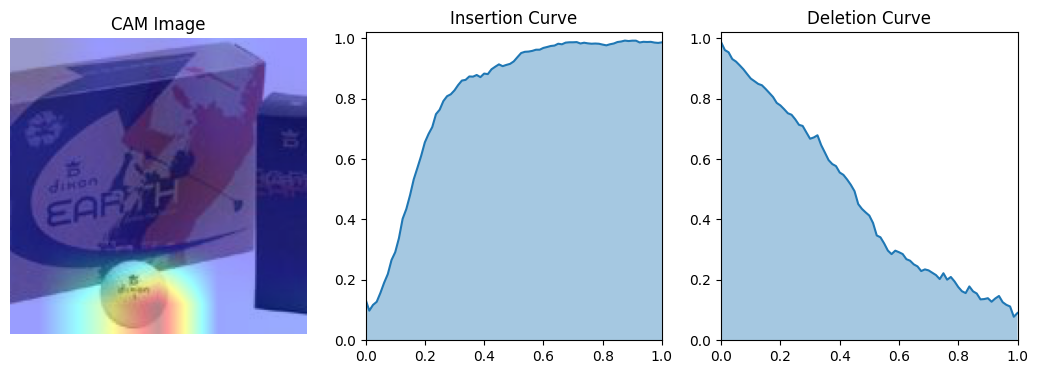

In [94]:
idx = 8
print(f'Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

### Grad-CAM++

In [95]:
mycam = cam.GradCAMpp(trainer.model, dataset, target_layer, cuda = cuda)
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[mycam.__class__.__name__] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
print(metrics[mycam.__class__.__name__])

{'Average Incr': 0.11999999731779099, 'Average Drop': 0.06496202200651169, 'Insertion': 0.7863634030718041, 'Deletion': 0.4668738601415739}


Pred: 8, Label: 8, Prob: 99.03%


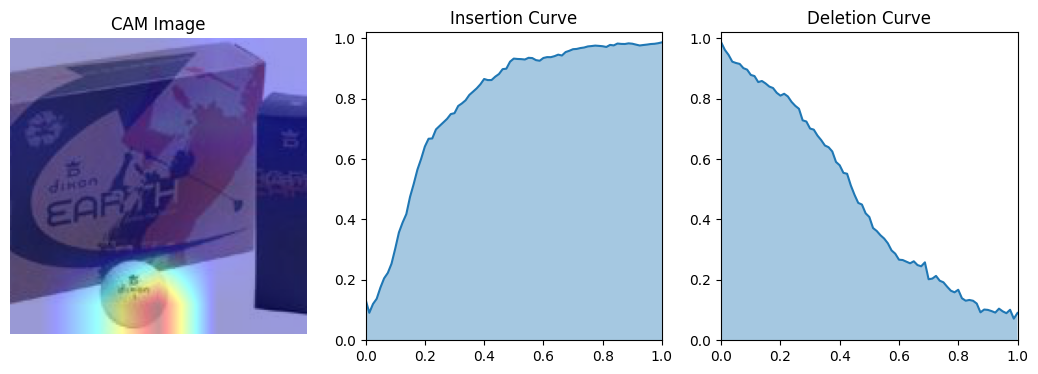

In [96]:
idx = 8
print(f'Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

## Smooth Grad-CAM++

In [97]:
mycam = cam.SMGradCAMpp(trainer.model, dataset, target_layer, cuda = cuda)
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[mycam.__class__.__name__] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
print(metrics[mycam.__class__.__name__])

{'Average Incr': 0.10999999940395355, 'Average Drop': 0.06543387472629547, 'Insertion': 0.7831743258720425, 'Deletion': 0.4810534634180392}


Pred: 8, Label: 8, Prob: 99.03%


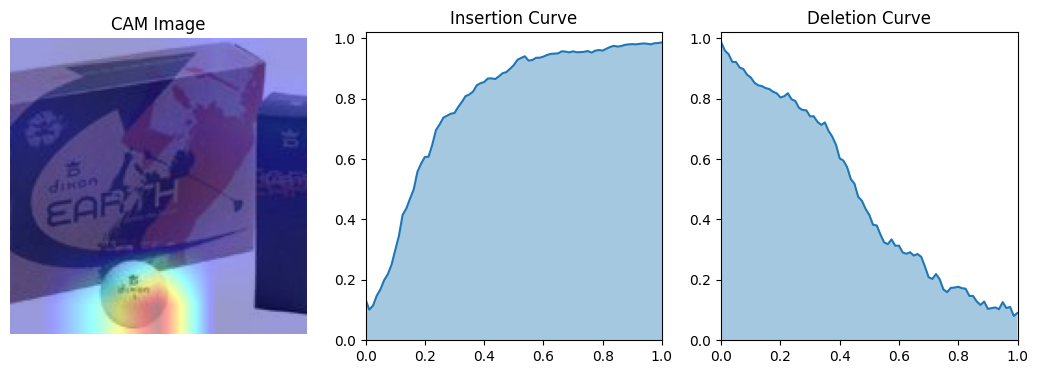

In [98]:
idx = 8
print(f'Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

### LayerCAM

In [99]:
mycam = cam.LayerCAM(trainer.model, dataset, target_layer, cuda = cuda)
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[mycam.__class__.__name__] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
print(metrics[mycam.__class__.__name__])

{'Average Incr': 0.11999999731779099, 'Average Drop': 0.06441902369260788, 'Insertion': 0.7862779647672105, 'Deletion': 0.464589642419056}


Pred: 8, Label: 8, Prob: 99.03%


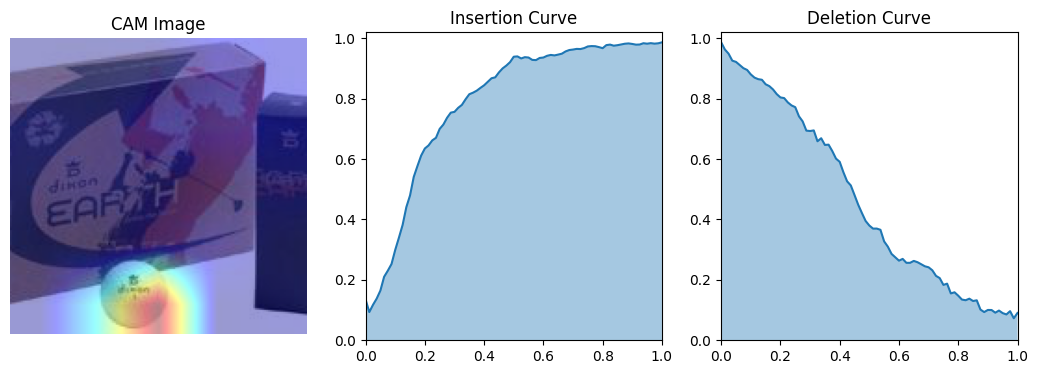

In [100]:
idx = 8
print(f'Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

### XGrad-CAM

In [101]:
mycam = cam.XGradCAM(trainer.model, dataset, target_layer, cuda = cuda)
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[mycam.__class__.__name__] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
print(metrics[mycam.__class__.__name__])

{'Average Incr': 0.25999999046325684, 'Average Drop': 0.008758722804486752, 'Insertion': 0.8071255259866684, 'Deletion': 0.4656252752276127}


Pred: 8, Label: 8, Prob: 99.03%


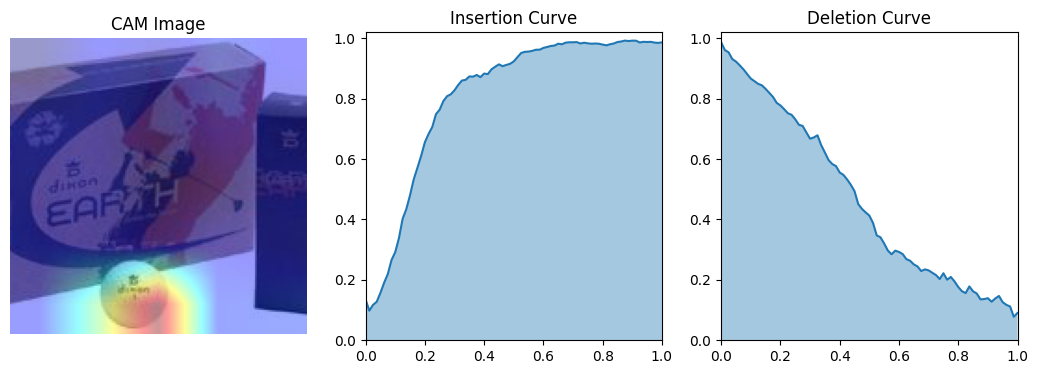

In [102]:
idx = 8
print(f'Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

### Score-CAM

In [103]:
mycam = cam.ScoreCAM(trainer.model, dataset, target_layer, cuda = cuda)
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[mycam.__class__.__name__] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
print(metrics[mycam.__class__.__name__])

{'Average Incr': 0.1599999964237213, 'Average Drop': nan, 'Insertion': 0.7717277829038898, 'Deletion': 0.5444126476895677}


Pred: 8, Label: 8, Prob: 99.03%


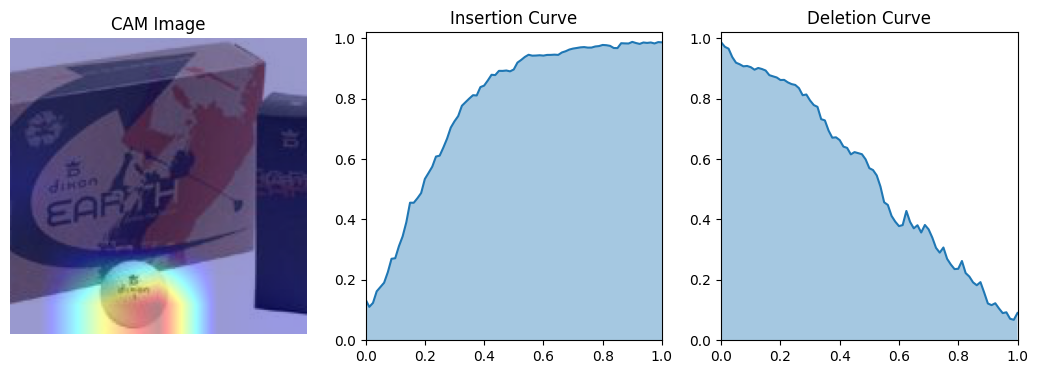

In [104]:
idx = 8
print(f'Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

## SS-CAM

In [105]:
mycam = cam.SSCAM(trainer.model, dataset, target_layer, cuda = cuda)
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[mycam.__class__.__name__] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
print(metrics[mycam.__class__.__name__])

{'Average Incr': 0.05999999865889549, 'Average Drop': 0.07480160146951675, 'Insertion': 0.773491146486239, 'Deletion': 0.49084313043030364}


Pred: 8, Label: 8, Prob: 99.03%


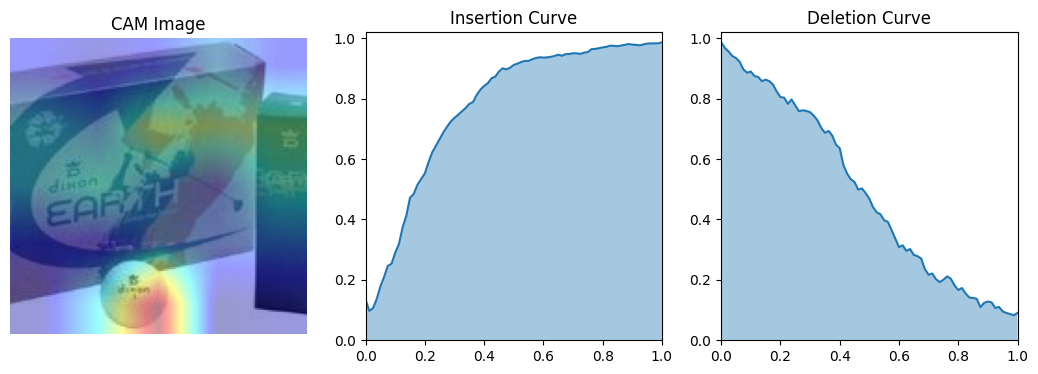

In [106]:
idx = 8
print(f'Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

## IS-CAM

In [107]:
mycam = cam.ISCAM(trainer.model, dataset, target_layer, cuda = cuda)
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[mycam.__class__.__name__] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
print(metrics[mycam.__class__.__name__])

{'Average Incr': 0.1899999976158142, 'Average Drop': nan, 'Insertion': 0.7617342481705083, 'Deletion': 0.519155374622364}


Pred: 8, Label: 8, Prob: 99.03%


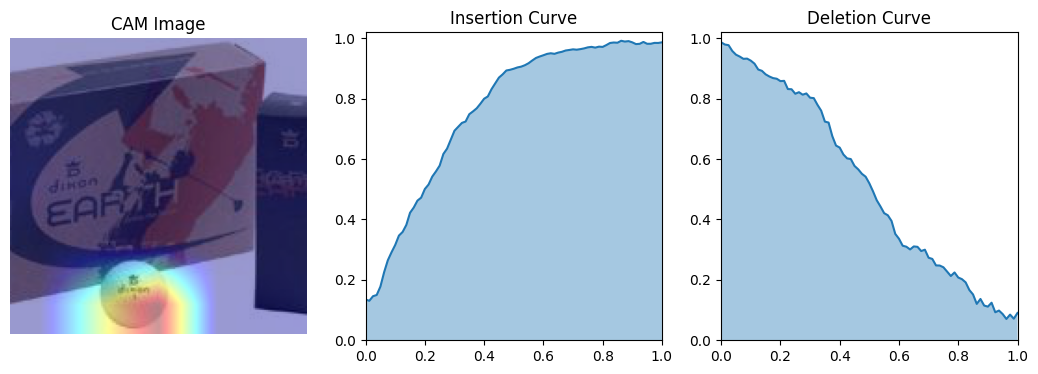

In [108]:
idx = 8
print(f'Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

In [109]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,GradCAM,GradCAMpp,SMGradCAMpp,LayerCAM,XGradCAM,ScoreCAM,SSCAM,ISCAM
Average Incr,0.260000,0.120000,0.110000,0.120000,0.260000,0.160000,0.060000,0.190000
Average Drop,0.008765,0.064962,0.065434,0.064419,0.008759,NaN,0.074802,NaN
Insertion,0.807129,0.786363,0.783174,0.786278,0.807126,0.771728,0.773491,0.761734
Deletion,0.465618,0.466874,0.481053,0.464590,0.465625,0.544413,0.490843,0.519155


In [110]:
df_pth = f'./thesis/metrics/{dataset}/'
import os
if not os.path.exists(df_pth):
    os.makedirs(df_pth)
metrics_df.to_csv(df_pth + f'CAM-{model_mode}-{dataset}-seed{seed}.csv')